In [16]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from datetime import datetime as dt
import timeit
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

from utils import dict_list, add_stats, get_stats, get_diffs
from utils_actlearn.gauss import *
from utils_actlearn.mes import mes, bootstrap_mes_stats
from utils_actlearn.scp_taylor import *
from utils_actlearn.scp_particle import *
from utils_plot import *

set_plt_settings()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test active learning approach

## Load data

In [5]:
data_in = np.load('../data/pca_encoding.npy')
# columns=['index', sample_num', 'operating_cost', 'market_rev', 'runtime'
data_out_base = pd.read_csv('../data/combined_basecase.csv', header=None)
data_out_hvdc = pd.read_csv('../data/combined_hvdc.csv', header=None)

D = 10
X = data_in[:,:D]
n, d = X.shape

f = data_out_hvdc.to_numpy()[:,2] - data_out_base.to_numpy()[:,2]
time_model = data_out_base.to_numpy()[:,4].mean()

In [6]:
fscale = StandardScaler().fit_transform(f.reshape(-1,1)).flatten()
Xscale = StandardScaler().fit_transform(X)

In [7]:
n0, N = 2, 100
n_bootstrap = 25
l = 2
save_mode = False

## Train surrogate model

In [17]:
results_true = dict_list()
results_true = add_stats(results_true, fscale, fscale)
results_true['runtime'] = [time_model*n]
stats = [k for k in results_true.keys() if not k.startswith('test_')]

### Random

In [9]:
bootstrap_rand, results_rand, fpreds_rand = bootstrap_mes_stats(
    'random', Xscale, fscale, N, n0, l, n_bootstrap, stats)

100%|███████████████████████████████████████████| 25/25 [05:17<00:00, 12.68s/it]


In [18]:
diffs_rand = get_diffs(bootstrap_rand, results_true)

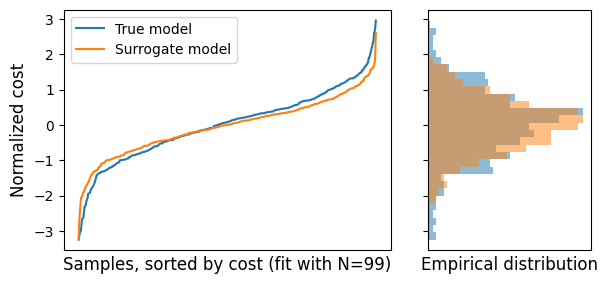

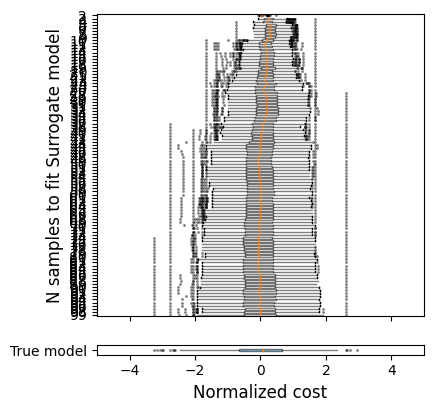

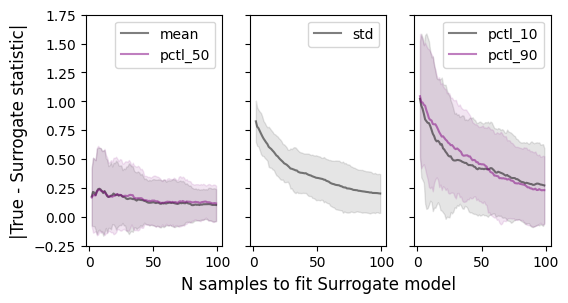

In [19]:
pre = 'rand'
results, fpreds = results_rand, fpreds_rand

file_names = [None, None, None]
if save_mode:
    file_names = [pre+'_dist', pre+'_boxplot', pre+'_statsboot']
plot_dist(fscale, fpreds[N-1], N = N-1, bins=30, save_file=file_names[0])
plot_boxplots(fscale, fpreds, xlim=(-5, 5), save_file=file_names[1])
plot_stats_boot(diffs_rand, n0, N, save_file=file_names[2])

### Taylor approximation SCP

In [21]:
bootstrap_taylor, results_taylor, fpreds_taylor = bootstrap_mes_stats(
    scp_taylor, Xscale, fscale, N, n0, l, n_bootstrap, stats)

100%|████████████████████████████████████████| 25/25 [2:03:00<00:00, 295.23s/it]


In [30]:
diffs_taylor = get_diffs(bootstrap_taylor, results_true)

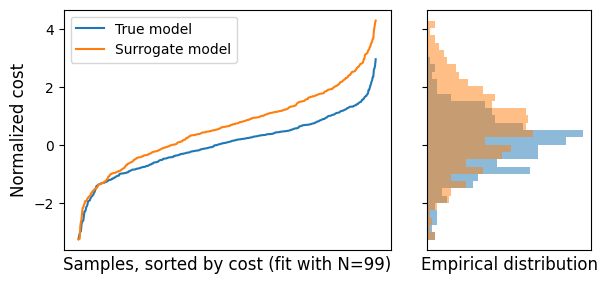

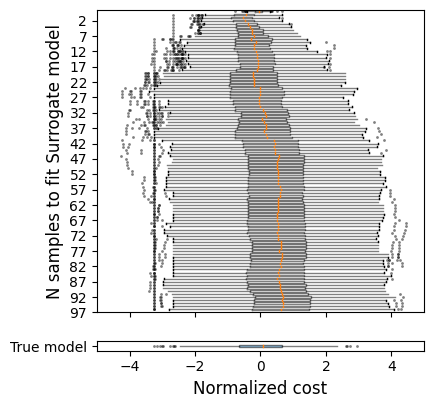

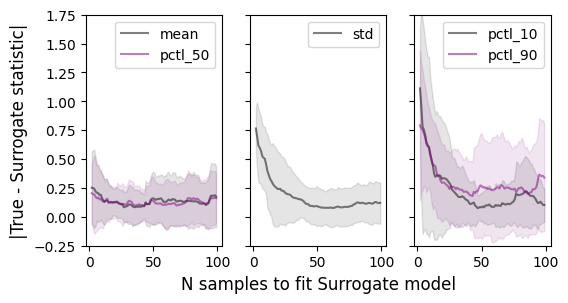

In [31]:
pre = 'taylor'
results, fpreds = results_taylor, fpreds_taylor

file_names = [None, None, None]
if save_mode:
    file_names = [pre+'_dist', pre+'_boxplot', pre+'_statsboot']
plot_dist(fscale, fpreds[N-1], N = N-1, bins=30, save_file=file_names[0])
plot_boxplots(fscale, fpreds, xlim=(-5, 5), save_file=file_names[1])
plot_stats_boot(diffs_taylor, n0, N, save_file=file_names[2])

### Particle method approximation SCP

In [ ]:
bootstrap_particle, results_particle, fpreds_particle = bootstrap_mes_stats(
    scp_particle, Xscale, fscale, N, n0, l, n_bootstrap, stats)

In [ ]:
diffs_particle = get_diffs(bootstrap_rand, results_true)

In [ ]:
pre = 'particle'
results, fpreds = results_particle, fpreds_particle

file_names = [None, None, None]
if save_mode:
    file_names = [pre+'_dist', pre+'_boxplot', pre+'_statsboot']
plot_dist(fscale, fpreds[N-1], N = N-1, bins=30, save_file=file_names[0])
plot_boxplots(fscale, fpreds, xlim=(-5, 5), save_file=file_names[1])
plot_stats_boot(diffs_particle, n0, N, save_file=file_names[2])

### Brute force

In [12]:
bootstrap_brute, results_brute, fpreds_brute = bootstrap_mes_stats(
    'brute', Xscale, fscale, N, n0, l, n_bootstrap, stats)

100%|█████████████████████████████████████| 100/100 [10:14:26<00:00, 368.66s/it]


In [24]:
diffs_brute = get_diffs(bootstrap_rand, results_true)

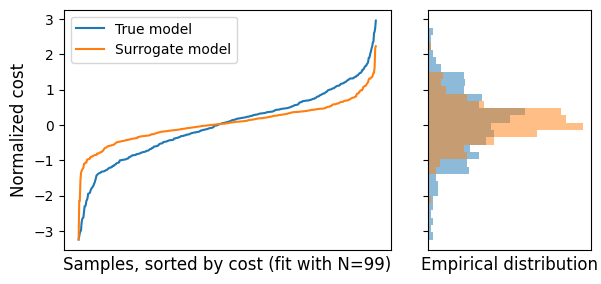

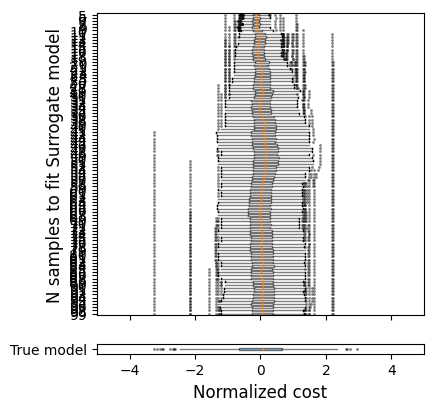

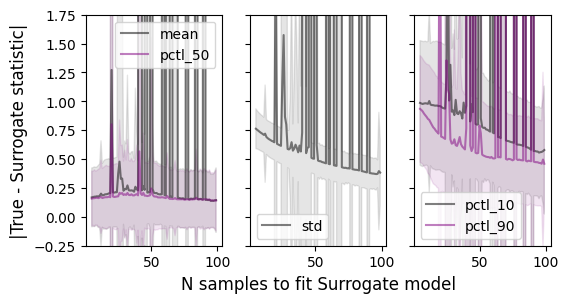

In [ ]:
pre = 'brute'
results, fpreds = results_brute, fpreds_brute

file_names = [None, None, None]
if save_mode:
    file_names = [pre+'_dist', pre+'_boxplot', pre+'_statsboot']
plot_dist(fscale, fpreds[N-1], N = N-1, bins=30, save_file=file_names[0])
plot_boxplots(fscale, fpreds, xlim=(-5, 5), save_file=file_names[1])
plot_stats_boot(diffs_brute, n0, N, save_file=file_names[2])

## Summarize

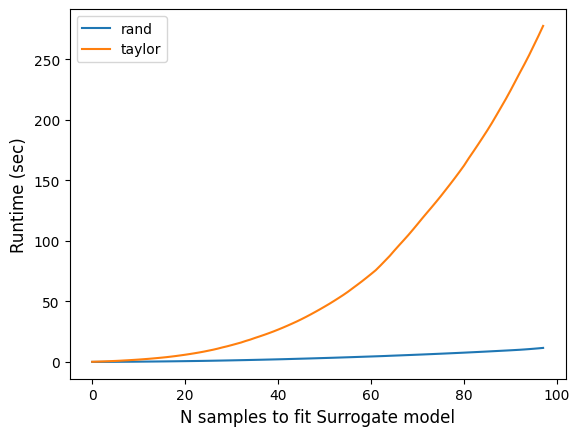

In [25]:
plt.plot(results_rand['runtime'], label='rand')
# plt.plot(results_brute['runtime'], label='brute')
plt.plot(results_taylor['runtime'], label='taylor')
# plt.plot(results_particle['runtime'], label='particle')
plt.ylabel('Runtime (sec)')
plt.xlabel('N samples to fit Surrogate model')
plt.legend()
plt.show()

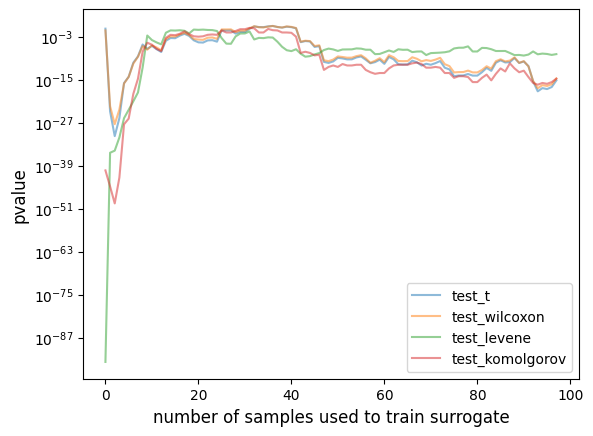

In [26]:
results = results_taylor
for test in results.keys():
    if test.startswith('test_'):
        plt.plot(results[test], alpha=0.5, label=test)

plt.legend()
plt.yscale('log')
plt.ylabel('pvalue')
plt.xlabel('number of samples used to train surrogate')
plt.show()

In [28]:
diffs = diffs_taylor
summ = {}
for k in diffs.keys():    
    summ[k] = [f'{np.round(diffs[f"{k}_mean"][-1],2)}±{np.round(diffs[f"{k}_std"][-1],2)}']
print(pd.DataFrame(summ).T.to_latex())

KeyError: 'pctl_0_mean_mean'

In [29]:
diffs

{'pctl_0_mean': array([2.28381667, 2.07544232, 2.00094751, 1.92824141, 1.83267034,
        1.79796381, 1.70332183, 1.63865309, 1.52955832, 1.52207193,
        1.45090899, 1.40663744, 1.35728914, 1.35609393, 1.33535679,
        1.23711406, 1.19504729, 1.19601415, 1.16935425, 1.10003638,
        1.03709315, 0.9803672 , 0.97373707, 0.97363536, 0.88996659,
        0.82859333, 0.78699495, 0.74470001, 0.7282464 , 0.72346063,
        0.71708169, 0.71669581, 0.71397745, 0.71188893, 0.71192561,
        0.66825865, 0.67010085, 0.66363673, 0.66200241, 0.66329222,
        0.66394907, 0.65899683, 0.65636709, 0.64785607, 0.62851937,
        0.60868546, 0.60911275, 0.57633628, 0.57760374, 0.57500093,
        0.57516435, 0.57019757, 0.56813814, 0.56994962, 0.56487914,
        0.55214288, 0.55164474, 0.53948495, 0.45072536, 0.45124355,
        0.45216093, 0.44971479, 0.45056429, 0.42727733, 0.42593094,
        0.4250137 , 0.43646405, 0.43599422, 0.43768329, 0.42994387,
        0.43788226, 0.43346801, 0